<a href="https://colab.research.google.com/github/Zinwaiyan274/Twitter-sentiment-analysis-using-RNN-and-GloVe-embedding/blob/main/Bidirectional_LSTM_with_GloVe_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/ngyptr/lstm-sentiment-analysis-keras

In [ ]:
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [ ]:
#essential libs
import pandas as pd
import numpy as np

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

headers=['ID','Entity','label','Feature']
train_data = pd.read_csv("https://raw.githubusercontent.com/Zinwaiyan274/Twitter-Sentiment-Analysis/main/twitter_training.csv", sep=',', names=headers)
val_data = pd.read_csv("https://raw.githubusercontent.com/Zinwaiyan274/Twitter-Sentiment-Analysis/main/twitter_validation.csv", sep=',', names=headers)

df = train_data.append(val_data)
# df = train_data

# train data = df

# for train_df data
df["label"] = df["label"].replace("Positive" , "1")
df["label"] = df["label"].replace("Negative", "-1")
df["label"] = df["label"].replace("Neutral", "0" )
df = df[df["label"].str.contains("Irrelevant") == False]
# df = df.dropna(how='any', inplace=True)



# #for val data
val_data = val_data.drop(columns=["ID", "Entity"], axis=1)
val_data["label"] = val_data["label"].replace("Positive" , "1")
val_data["label"] = val_data["label"].replace("Negative", "-1")
val_data["label"] = val_data["label"].replace("Neutral", "0" )
val_data = val_data[val_data["label"].str.contains("Irrelevant") == False]
val_data = val_data.drop_duplicates()
# val_data = val_data.dropna(how='any', inplace=True)
# Y_val = pd.get_dummies(val_data["label"])

# val_data
# Y_val
# df["label"].unique()
# val_data


In [ ]:
val_data

,label,Feature
1,0,BBC News - Amazon boss Jeff Bezos rejects clai...
2,-1,@Microsoft Why do I pay for WORD when it funct...
3,-1,"CSGO matchmaking is so full of closet hacking,..."
4,0,Now the President is slapping Americans in the...
5,-1,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
993,-1,Please explain how this is possible! How can t...
994,1,Good on Sony. As much as I want to see the new...
997,1,Today sucked so it’s time to drink wine n play...
998,1,Bought a fraction of Microsoft today. Small wins.


In [ ]:
import re
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "



# How about stop words??

import nltk
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

def clean(text):  
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text



from nltk.parse.transitionparser import remove



#remove link
def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet



# df['Feature']= df["Feature"].apply(preprocess_reviews)
df['Feature']= df["Feature"].apply(clean)
# df['Feature']= df["Feature"].apply(preprocess)
df['Feature']= df["Feature"].apply(remove_links)



#remove twitter user ( acc username)
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet


df['Feature']= df["Feature"].apply(remove_users)



#remove punctuation
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower()
    sent = re.sub('['+my_punctuation + ']+', ' ', sent) # strip punctuation
    sent = re.sub('\s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent

df['Feature']= df["Feature"].apply(preprocess)



# remove emoticons


!pip install emoji
import emoji
import regex as re
# import renew_tweet
import sys
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


df['Feature']= df["Feature"].apply(remove_emoji)

import re
from nltk.stem.porter import *
from nltk.corpus import stopwords

def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

df['Feature']= df["Feature"].apply(tweet_to_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 13.1 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=1c1ee898540a82da77b0a82d1c01b0a84885006f695fab0e02b8efea409f8456
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [ ]:
val_X= val_data["Feature"].apply(tweet_to_words)
val_Y= val_data["label"]
val_X 

1      [bbc, news, amazon, boss, jeff, bezo, reject, ...
2      [microsoft, pay, word, function, poorli, samsu...
3      [csgo, matchmak, full, closet, hack, truli, aw...
4      [presid, slap, american, face, realli, commit,...
5      [hi, eahelp, madelein, mccann, cellar, past, 1...
                             ...                        
993    [pleas, explain, possibl, let, compani, overch...
994    [good, soni, much, want, see, new, ps5, go, ri...
997    [today, suck, time, drink, wine, n, play, bord...
998     [bought, fraction, microsoft, today, small, win]
999    [johnson, johnson, stop, sell, talc, babi, pow...
Name: Feature, Length: 827, dtype: object

In [ ]:
# We could see that some columns are not totally useful for us, So I gonna drop them to clean

# df = df.drop(df.columns[[0, 1]],axis = 1)
# df = df.drop_duplicates()

df = df.dropna()

# df

# #above is for train_data, below is for val data

# val_data = val_data(val_data.columns[[0, 1]],axis = 1)

df.head()
                              

,ID,Entity,label,Feature
0,2401,Borderlands,1,"[get, borderland, murder]"
1,2401,Borderlands,1,"[come, border]"
2,2401,Borderlands,1,"[get, borderland]"
3,2401,Borderlands,1,"[come, borderland, murder]"
4,2401,Borderlands,1,"[get, borderland, murder]"


In [ ]:
X = df["Feature"]

X

0                              [get, borderland, murder]
1                                         [come, border]
2                                      [get, borderland]
3                             [come, borderland, murder]
4                              [get, borderland, murder]
                             ...                        
993    [plea, explain, possibl, let, compani, overcha...
994    [good, soni, much, want, see, new, go, right, ...
997    [today, suck, time, drink, wine, n, play, bord...
998       [bought, fraction, microsoft, today, small, w]
999    [johnson, johnson, stop, sell, talc, babi, pow...
Name: Feature, Length: 62520, dtype: object

In [ ]:
# df['label']
Y = df['label']
Y = pd.get_dummies(Y)
# Y = Y.iloc[:20401] 

Y.shape

(62520, 3)

In [ ]:
# val_data.to_csv()
val_data.to_csv("val", sep='\t', encoding='utf-8')

In [ ]:
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df["Feature"],Y, test_size = 0.33, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_train,Y_train, train_size = 0.75)

X_train
#train
max_fatures = 30000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')


tokenizer.fit_on_texts(X_train.values)
word_ind = tokenizer.word_index
X_train = tokenizer.texts_to_sequences(X_train.values)
X_train = pad_sequences(X_train)

max_length = 163

#val
X_val 
X_val = tokenizer.texts_to_sequences(X_val.values)
X_val = pad_sequences(X_val,max_length )

#test

X_test = tokenizer.texts_to_sequences(X_test.values)
X_test = pad_sequences(X_test,max_length )
len(word_ind)

# val_X = tokenizer.texts_to_sequences(val_X.values)
val_X = pad_sequences(val_X,max_length )
val_X



ValueError: ignored

In [ ]:
X_val 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df["Feature"],Y, test_size = 0.33, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_train,Y_train, train_size = 0.75)

X_train
#train
max_fatures = 30000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
it_on_texts(X_train.values)

tokenizer.fit_on_texts(X_train.values)
word_ind = tokenizer.word_index
X_train = tokenizer.texts_to_sequences(X_train.values)
X_train = pad_sequences(X_train)

max_length = 163

#val
X_val 
X_val = tokenizer.texts_to_sequences(X_val.values)
X_val = pad_sequences(X_val,max_length )

#test

X_test = tokenizer.texts_to_sequences(X_test.values)
X_test = pad_sequences(X_test,max_length )
len(word_ind)


val_X = tokenizer.texts_to_sequences(val_X.values)
val_X = pad_sequences(val_X,max_length )
val_X


array([[    0,     0,     0, ...,   154,  4177, 18398],
       [    0,     0,     0, ...,  1508,  8603, 10078],
       [    0,     0,     0, ...,   629,   840,     1],
       ...,
       [    0,     0,     0, ...,   126,    23,   385],
       [    0,     0,     0, ...,    63,   650,   101],
       [    0,     0,     0, ...,  2903,  2305,   660]], dtype=int32)

In [ ]:
# val_data.to_csv()
val_data.to_csv("val", sep='\t', encoding='utf-8')

In [ ]:
word_index = tokenizer.word_index
print(word_index)
word_index

{'game': 1, 'play': 2, 'get': 3, 'like': 4, 'fuck': 5, 'go': 6, 'time': 7, 'one': 8, 'good': 9, 'johnson': 10, 'realli': 11, 'im': 12, 'love': 13, 'make': 14, 'new': 15, 'shit': 16, 'still': 17, 'thank': 18, 'look': 19, 'see': 20, 'peopl': 21, 'year': 22, 'day': 23, 'cant': 24, 'dead': 25, 'best': 26, 'got': 27, 'amazon': 28, 'xbox': 29, 'microsoft': 30, 'great': 31, 'even': 32, 'dont': 33, 'want': 34, 'googl': 35, 'verizon': 36, 'plea': 37, 'rhandlerr': 38, 'red': 39, 'fix': 40, 'work': 41, 'facebook': 42, 'back': 43, 'say': 44, 'much': 45, 'us': 46, 'home': 47, 'call': 48, 'tri': 49, 'borderland': 50, 'come': 51, 'first': 52, 'use': 53, 'fifa': 54, 'ever': 55, 'know': 56, 'wait': 57, 'guy': 58, 'would': 59, 'watch': 60, 'bad': 61, 'help': 62, 'today': 63, 'player': 64, 'also': 65, 'video': 66, 'thing': 67, 'think': 68, 'redempt': 69, 'need': 70, 'world': 71, 'v': 72, 'eamaddennfl': 73, 'pubg': 74, 'nvidia': 75, 'stop': 76, 'everi': 77, 'legend': 78, 'buy': 79, 'excit': 80, 'updat': 8

{'game': 1,
 'play': 2,
 'get': 3,
 'like': 4,
 'fuck': 5,
 'go': 6,
 'time': 7,
 'one': 8,
 'good': 9,
 'johnson': 10,
 'realli': 11,
 'im': 12,
 'love': 13,
 'make': 14,
 'new': 15,
 'shit': 16,
 'still': 17,
 'thank': 18,
 'look': 19,
 'see': 20,
 'peopl': 21,
 'year': 22,
 'day': 23,
 'cant': 24,
 'dead': 25,
 'best': 26,
 'got': 27,
 'amazon': 28,
 'xbox': 29,
 'microsoft': 30,
 'great': 31,
 'even': 32,
 'dont': 33,
 'want': 34,
 'googl': 35,
 'verizon': 36,
 'plea': 37,
 'rhandlerr': 38,
 'red': 39,
 'fix': 40,
 'work': 41,
 'facebook': 42,
 'back': 43,
 'say': 44,
 'much': 45,
 'us': 46,
 'home': 47,
 'call': 48,
 'tri': 49,
 'borderland': 50,
 'come': 51,
 'first': 52,
 'use': 53,
 'fifa': 54,
 'ever': 55,
 'know': 56,
 'wait': 57,
 'guy': 58,
 'would': 59,
 'watch': 60,
 'bad': 61,
 'help': 62,
 'today': 63,
 'player': 64,
 'also': 65,
 'video': 66,
 'thing': 67,
 'think': 68,
 'redempt': 69,
 'need': 70,
 'world': 71,
 'v': 72,
 'eamaddennfl': 73,
 'pubg': 74,
 'nvidia': 75,

In [ ]:
 y_test

,-1,0,1
28445,0,1,0
5069,0,1,0
50976,0,0,1
64311,1,0,0
4364,0,0,1
...,...,...,...
16223,1,0,0
19387,0,1,0
57494,0,1,0
51272,0,1,0


In [ ]:
X_val

array([[    0,     0,     0, ...,  2745,   191,  1797],
       [    0,     0,     0, ...,  3769,    53,   163],
       [    0,     0,     0, ...,  2776,   145,  1237],
       ...,
       [    0,     0,     0, ..., 11054,    18,   100],
       [    0,     0,     0, ...,  1883,  8362,   759],
       [    0,     0,     0, ...,    78,   180,   189]], dtype=int32)

In [ ]:
X.shape

In [ ]:
y_val

,-1,0,1
72380,0,1,0
24794,0,0,1
5123,0,1,0
55469,1,0,0
13853,1,0,0
...,...,...,...
16133,0,0,1
16383,0,1,0
17611,0,0,1
44389,0,0,1


In [ ]:
X_train

array([[    0,     0,     0, ...,     0,   140,    16],
       [    0,     0,     0, ...,    74,   274,  6749],
       [    0,     0,     0, ...,     0,    18,    38],
       ...,
       [    0,     0,     0, ..., 10768,   197,     7],
       [    0,     0,     0, ...,    24,    18,   305],
       [    0,     0,     0, ...,  2077,    90,   249]], dtype=int32)

In [ ]:
Y_train

,-1,0,1
74258,1,0,0
42132,1,0,0
15718,0,0,1
71116,0,1,0
56064,0,1,0
...,...,...,...
66637,0,0,1
47044,1,0,0
956,0,0,1
19281,0,0,1


pre trained

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 19321


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2022-10-17 15:09:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-17 15:09:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-17 15:09:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
embeddings_index = {}
# opening the downloaded glove embeddings file
f = open('/content/glove.6B.300d.txt')
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
import tensorflow as tf

# creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, 300))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector
embedding_layer = tf.keras.layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)

# 1st trail

This training is dropped whole layeer of Spitial Dropout




model

In [ ]:
import keras

def scheduler(epoch, lr):
       if epoch < 3:
        return lr
       else:
        return lr * tf.math.exp(-0.1)

early = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        mode = "min",
        patience=2,
        verbose=1,
    )
]

tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
ls_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

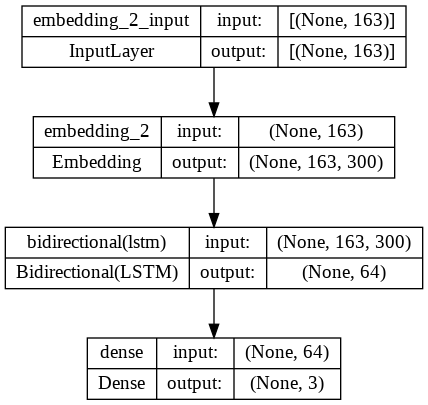

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
# from keras.optimizers import RMSprop 
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

embed_dim= 300
embedding_size = 300
# lstm_out = 196

# Build model
model= Sequential()
# model.add(Embedding(vocab_size, embed_dim,input_length = X.shape[1]))
model.add(Embedding(max_fatures, embedding_size, input_length= X_train.shape[1]))
# model.add(SpatialDropout1D(0.15))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(3, activation='softmax'))
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from keras.layers import Embedding,  Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD
epochs=50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer= "adam", 
               metrics=['accuracy', Precision(), Recall()])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 163, 300)          9000000   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               85248     
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 9,085,443
Trainable params: 9,085,443
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
y_train = Y_train

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((41888, 163), (41888, 3), (10472, 163), (10472, 3))

In [ ]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=64,
    epochs = 30, #epochs,
  callbacks= [ls_callback, early ], 
    validation_data=(X_val, y_val))

Epoch 1/30
655/655 [==============================] - 54s 70ms/step - loss: 0.6918 - accuracy: 0.7017 - precision: 0.7893 - recall: 0.5906 - val_loss: 0.3912 - val_accuracy: 0.8543 - val_precision: 0.9000 - val_recall: 0.8120 - lr: 0.0010
Epoch 2/30
655/655 [==============================] - 48s 74ms/step - loss: 0.3570 - accuracy: 0.8606 - precision: 0.8975 - recall: 0.8298 - val_loss: 0.2301 - val_accuracy: 0.9112 - val_precision: 0.9486 - val_recall: 0.8861 - lr: 0.0010
Epoch 3/30
655/655 [==============================] - 41s 62ms/step - loss: 0.2374 - accuracy: 0.9036 - precision: 0.9368 - recall: 0.8803 - val_loss: 0.1724 - val_accuracy: 0.9306 - val_precision: 0.9644 - val_recall: 0.9080 - lr: 0.0010
Epoch 4/30
655/655 [==============================] - 47s 72ms/step - loss: 0.1776 - accuracy: 0.9246 - precision: 0.9562 - recall: 0.9048 - val_loss: 0.1443 - val_accuracy: 0.9391 - val_precision: 0.9672 - val_recall: 0.9218 - lr: 9.0484e-04
Epoch 5/30
655/655 [====================

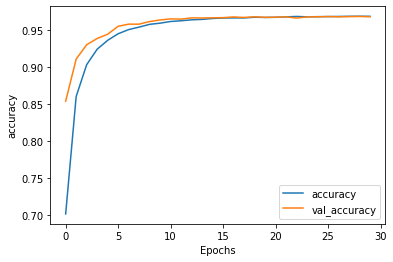

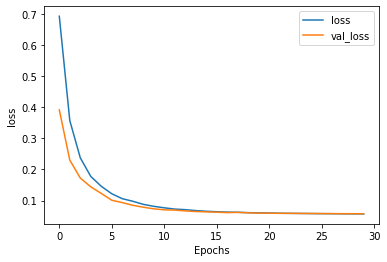

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
model.save('Pt_1st_model.h5')
